# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.500138,False,1.687967
1,0.466823,True,5.839436
2,-2.919384,False,-4.038461
3,1.439930,True,3.560690
4,0.855629,True,5.703588
...,...,...,...
995,-0.595835,False,1.363433
996,-0.823999,False,-0.338153
997,-0.620047,False,-0.662360
998,-0.144516,False,-1.496468


<Axes: xlabel='v0'>

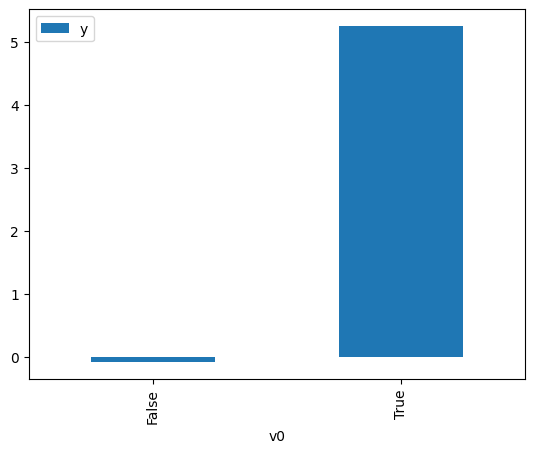

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

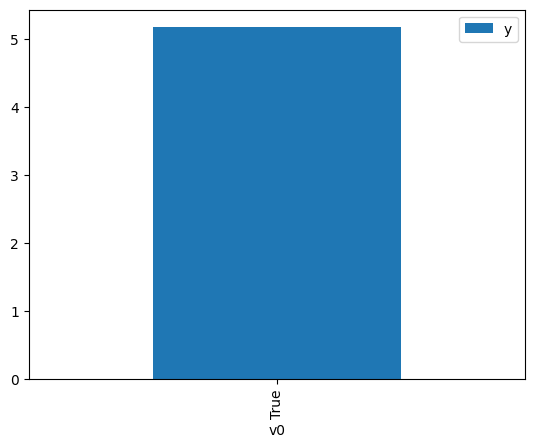

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.373936,False,-2.324388,0.972168,1.028629
1,-0.123468,False,0.521999,0.585670,1.707446
2,-0.545523,False,-0.632228,0.806682,1.239645
3,-1.016274,False,-2.097019,0.933142,1.071648
4,-1.201137,False,-1.586484,0.957309,1.044595
...,...,...,...,...,...
995,-0.678165,False,-0.387644,0.854308,1.170537
996,-1.338315,False,-1.087538,0.969586,1.031368
997,-0.919481,False,-0.349256,0.915887,1.091837
998,-0.383661,False,-0.752449,0.733694,1.362966


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.197738,True,4.429936,0.368983,2.710155
1,-0.277550,True,3.388937,0.322722,3.098640
2,0.076850,True,6.336151,0.541824,1.845618
3,1.127299,True,7.290749,0.945931,1.057159
4,-0.260597,True,5.629649,0.332298,3.009343
...,...,...,...,...,...
995,-1.507114,True,4.223933,0.019939,50.151964
996,-1.115126,True,1.771336,0.052673,18.984919
997,2.105436,True,8.543345,0.995371,1.004651
998,0.930646,True,6.694543,0.913531,1.094653


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.948
Model:                            OLS   Adj. R-squared (uncentered):              0.947
Method:                 Least Squares   F-statistic:                              9009.
Date:                Thu, 13 Jun 2024   Prob (F-statistic):                        0.00
Time:                        07:55:11   Log-Likelihood:                         -1434.3
No. Observations:                1000   AIC:                                      2873.
Df Residuals:                     998   BIC:                                      2882.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0594      0.038     27.748      0.000       0.984       1.134
x2             5.0657      0.052     97.656      0.000       4.964       5.167
==============================================================================
Omnibus:                        2.108   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.349   Jarque-Bera (JB):                2.088
Skew:                           0.070   Prob(JB):                        0.352
Kurtosis:                       2.826   Cond. No.                         1.94
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""